# Distribution of the Sobol' indices on Ishigami function

In this document, we consider the Ishigami function and check the distribution of the sensitivity indices. This distribution is computed by OpenTURNS and we check that it is consistent with the actual distribution of the estimator.

The problem is that the exact distribution of the estimator is unknown in general. The asymptotic distribution is known, but this may not reflect the true distribution when the sample size is not large enough. In order to get a reference distribution of the estimator, we generate a Monte-Carlo sample of the Sobol' indices, but repeating the estimation of the Sobol' indices on indepedent sub-samples. Then we use kernel smoothing to approximate the actual distribution of the Sobol' indices.

In [1]:
import openturns as ot
import otbenchmark as otb
import openturns.viewer as otv
import numpy as np
import pylab as pl

When we estimate Sobol' indices, we may encounter the following warning messages:
```
WRN - The estimated first order Sobol index (2) is greater than its total order index . You may increase the sampling size.
WRN - The estimated total order Sobol index (2) is lesser than first order index . You may increase the sampling size.
```
Lots of these messages are printed in the current Notebook. This is why we disable them with:

In [2]:
ot.Log.Show(ot.Log.NONE)

In [3]:
problem = otb.IshigamiSensitivity()
print(problem)

name = Ishigami
distribution = ComposedDistribution(Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), Uniform(a = -3.14159, b = 3.14159), IndependentCopula(dimension = 3))
function = ParametricEvaluation([X1,X2,X3,a,b]->[sin(X1) + a * sin(X2)^2 + b * X3^4 * sin(X1)], parameters positions=[3,4], parameters=[a : 7, b : 0.1], input positions=[0,1,2])
firstOrderIndices = [0.313905,0.442411,0]
totalOrderIndices = [0.557589,0.442411,0.243684]


In the following loop, we compare the distribution of the sensitivity indices computed by OpenTURNS and the actual distribution of the estimator computed by Monte-Carlo sampling (using kernel smoothing). The distribution of the sensitivity indices can be computed either from bootstrap (using kernel smoothing to approximate the distribution) or from asymptotic analysis (using a Gaussian distribution). 

In both cases, the distribution is estimated using one sample only. On the contrary, the actual distribution of the estimator (i.e. the reference distribution) is computing by generating independent realizations of the estimator. Hence, it is expected that the distribution computed by OpenTURNS is not centered on the true value of the sensitivity indices. Instead, the distribution based on the sample of estimators must be centered on the true value of the index, since these estimators are consistent, converge to the true value when the sample size increase and have no observable bias (although this is not proven by theory). 

The two essential parameters in the script are the following:
- `sampleSize` is the size of the sample used to estimated on set of sensitivity indices (the number of sensitivity indices is equal to twice, because of first and total order Sobol' indices, the product of the number of input variables),
- `numberOfRepetitions` is the size of the Monte-Carlo sample of sensitivity indices.

We do not necessarily want to use a large value of `sampleSize`. This may be required, however, if we want to check the asymptotic distribution computed by OpenTURNS, because the asymptotic regime may not be reached for small values and the code cannot be blamed for that. This is why the asymptotic option may fail if `sampleSize` is not large enough. The bootstrap option may fail too, because the sample size may be so small that re-sampling in the basic sample may not provide enough variability.

The value of `numberOfRepetitions` must be as large as possible because it ensures that the reference distribution used for this verification is accurate enough.

sampleSize= 100
Bootstrap
Estimator: Saltelli


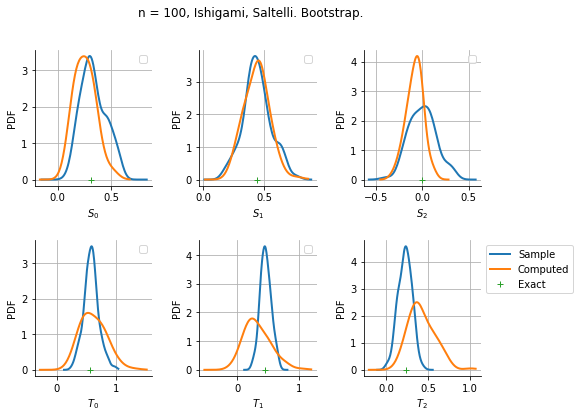

Estimator: Martinez


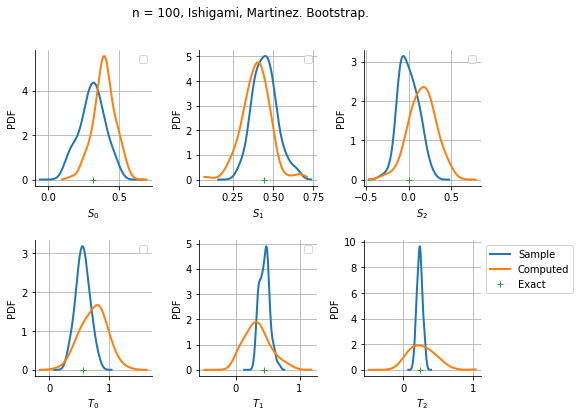

Estimator: Jansen


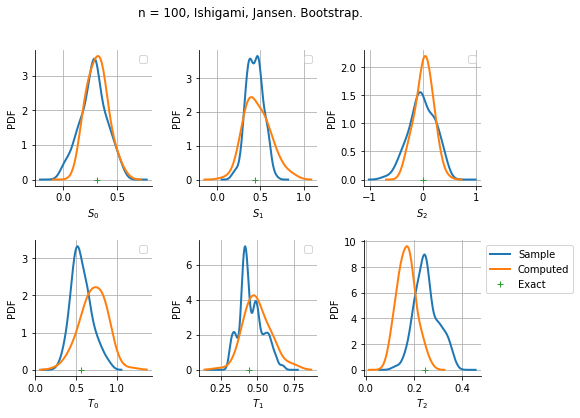

Estimator: MauntzKucherenko


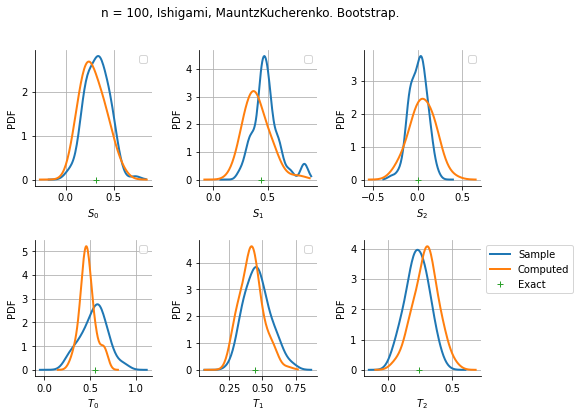

Asymptotic
Estimator: Saltelli


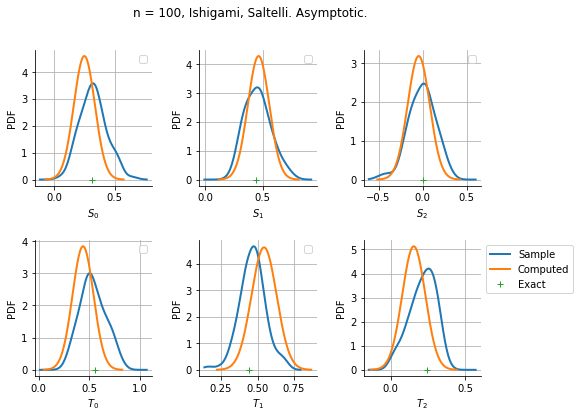

Estimator: Martinez


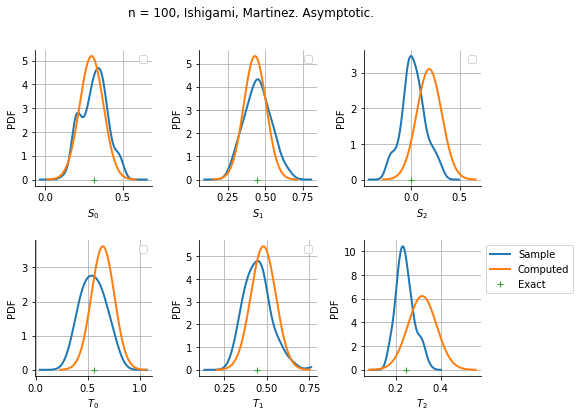

Estimator: Jansen


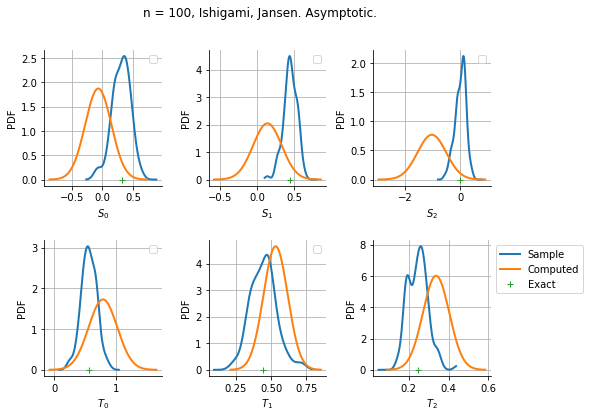

Estimator: MauntzKucherenko


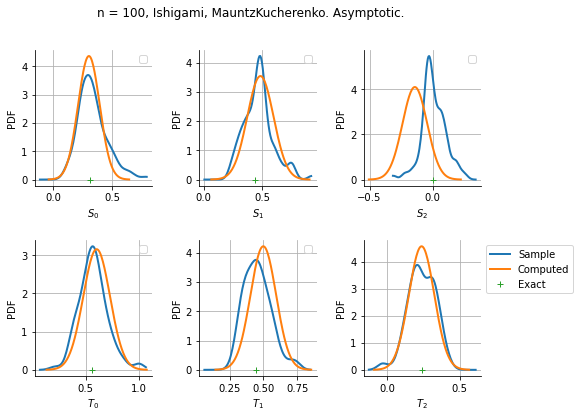

sampleSize= 200
Bootstrap
Estimator: Saltelli


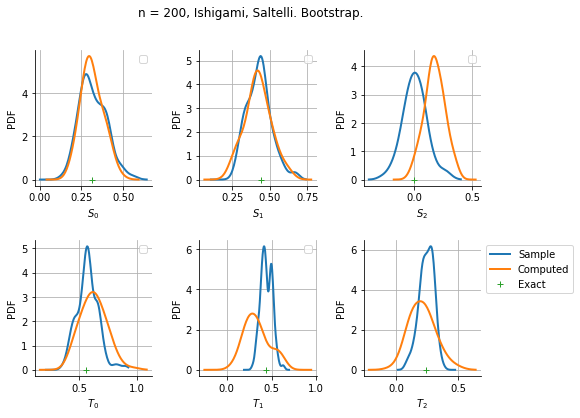

Estimator: Martinez


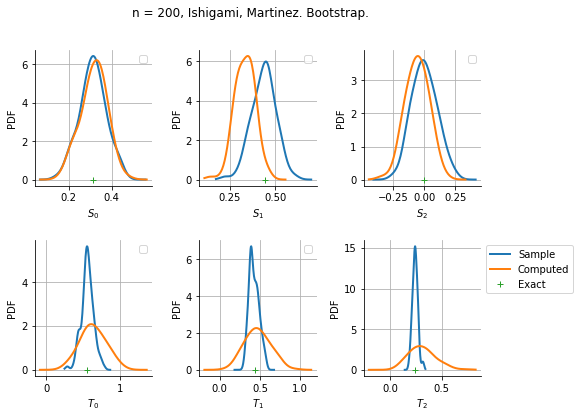

Estimator: Jansen


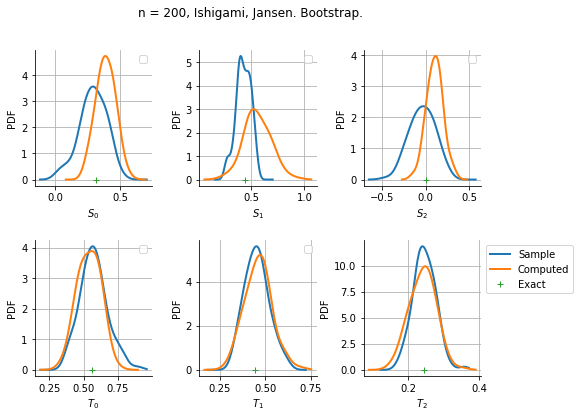

Estimator: MauntzKucherenko


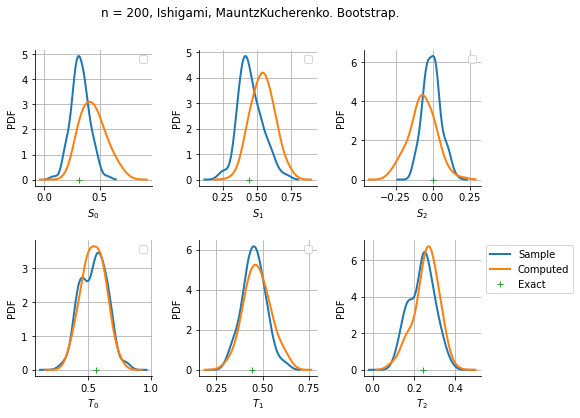

Asymptotic
Estimator: Saltelli


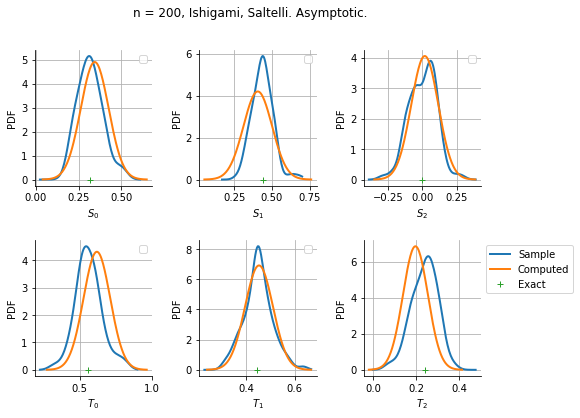

Estimator: Martinez


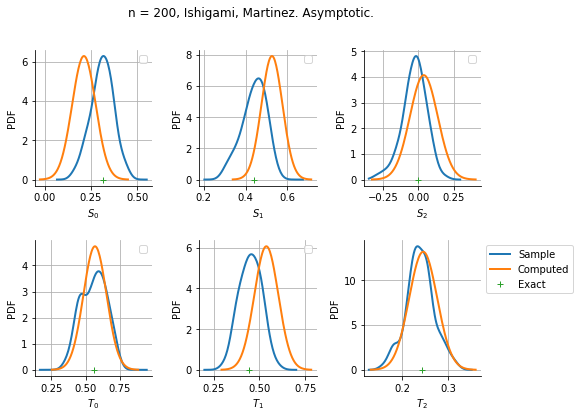

Estimator: Jansen


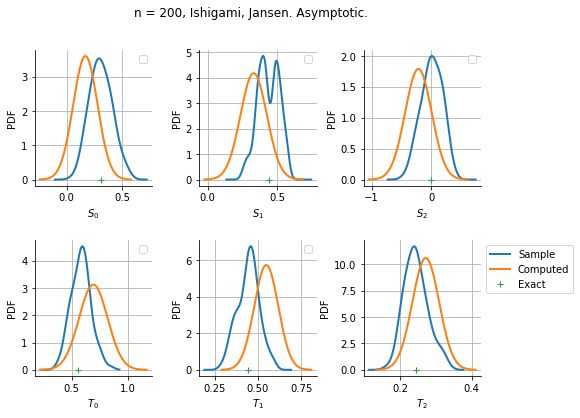

Estimator: MauntzKucherenko


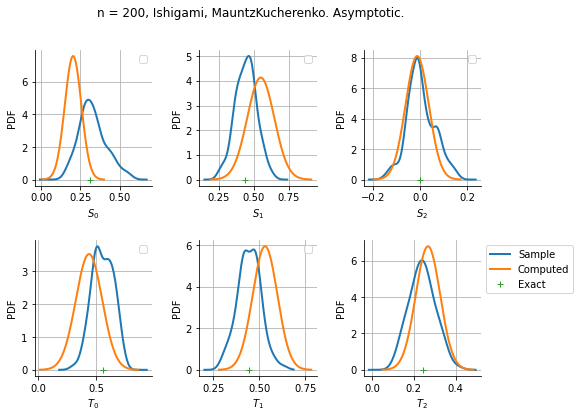

sampleSize= 400
Bootstrap
Estimator: Saltelli


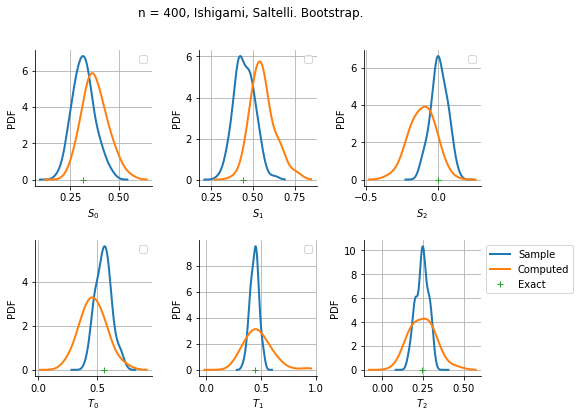

Estimator: Martinez


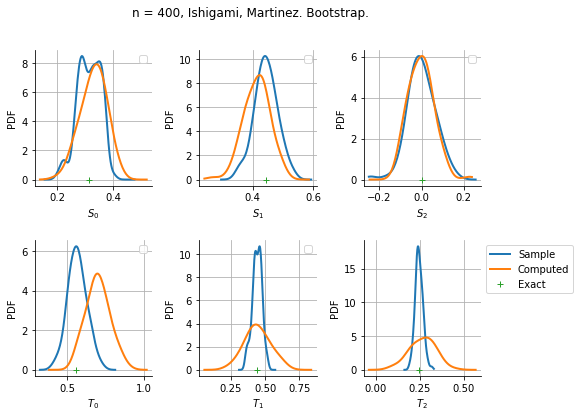

Estimator: Jansen


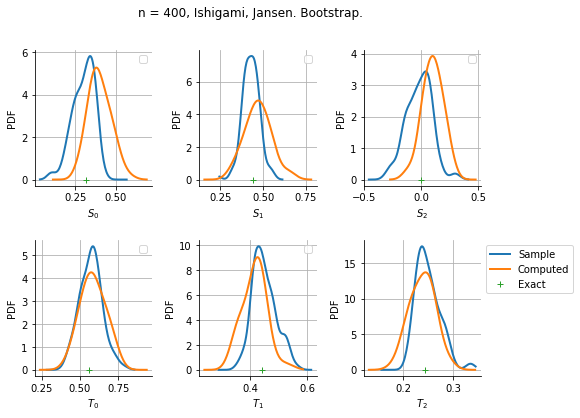

Estimator: MauntzKucherenko


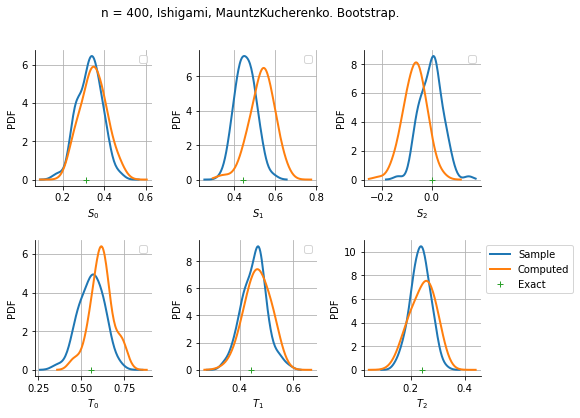

Asymptotic
Estimator: Saltelli


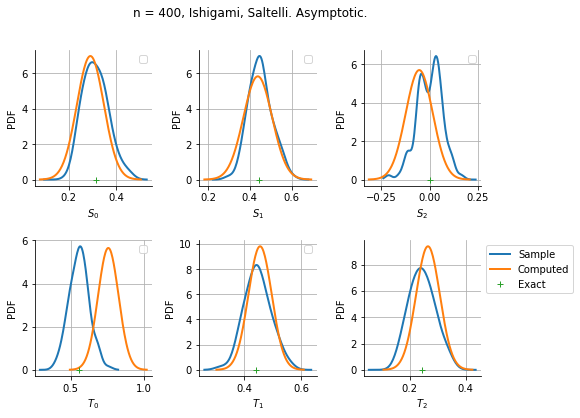

Estimator: Martinez


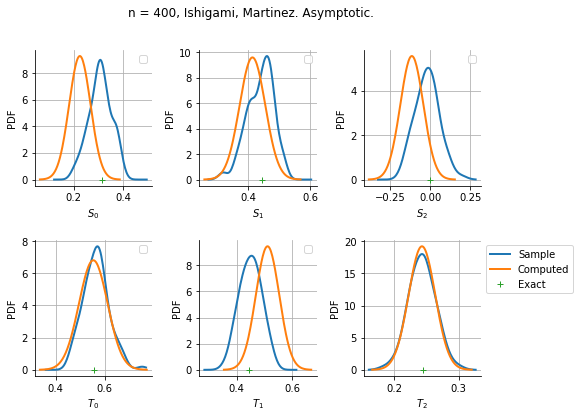

Estimator: Jansen


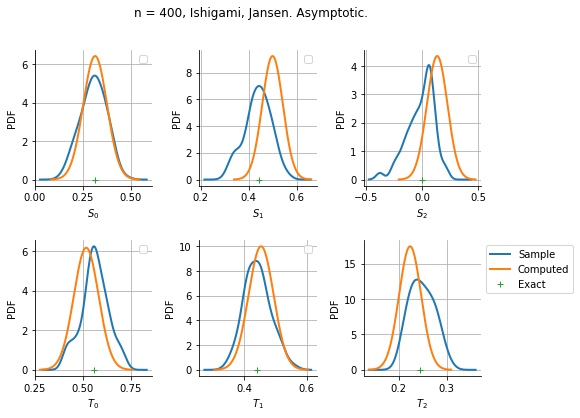

Estimator: MauntzKucherenko


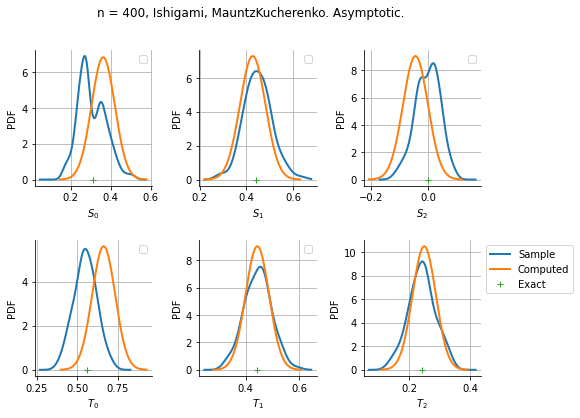

sampleSize= 800
Bootstrap
Estimator: Saltelli


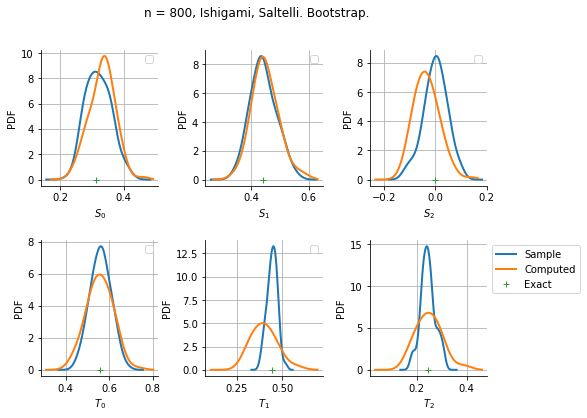

Estimator: Martinez


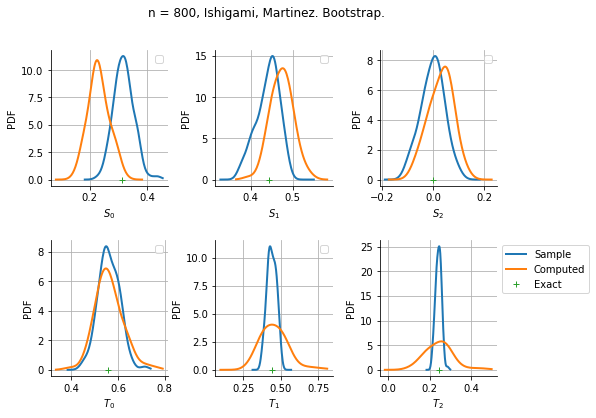

Estimator: Jansen


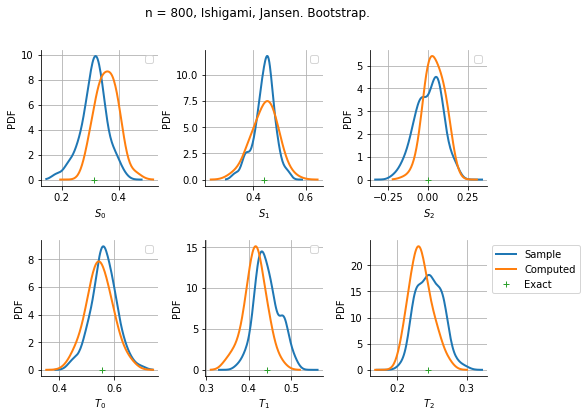

Estimator: MauntzKucherenko


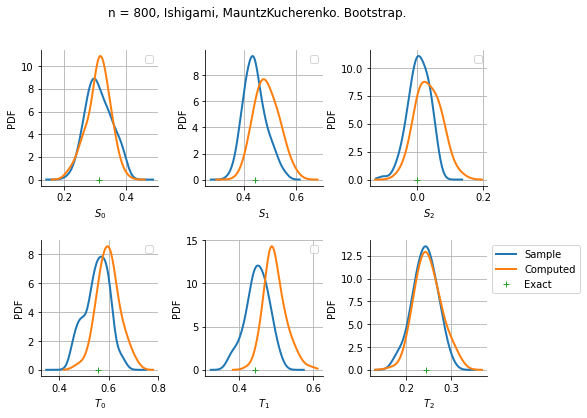

Asymptotic
Estimator: Saltelli


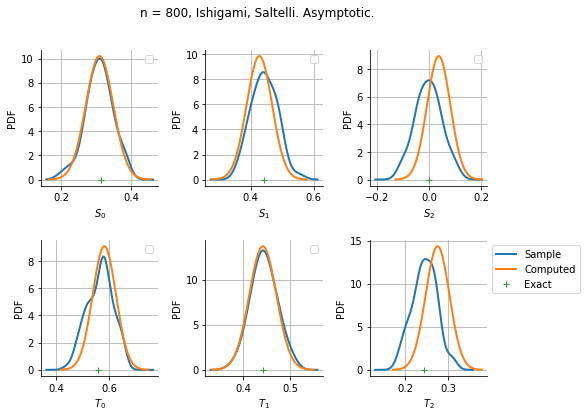

Estimator: Martinez


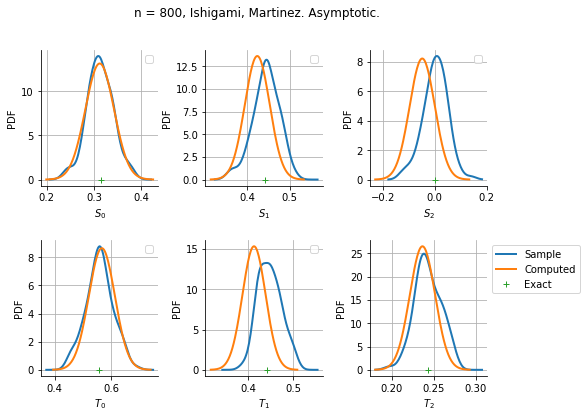

Estimator: Jansen


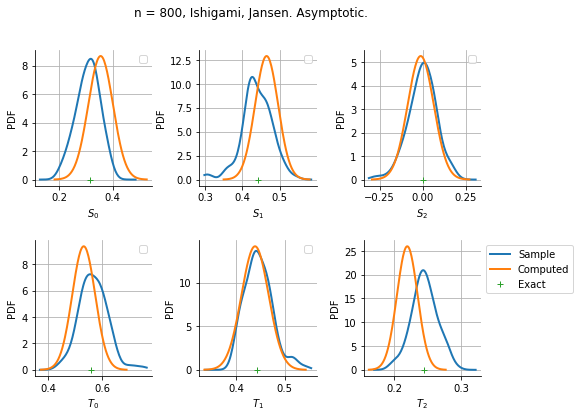

Estimator: MauntzKucherenko


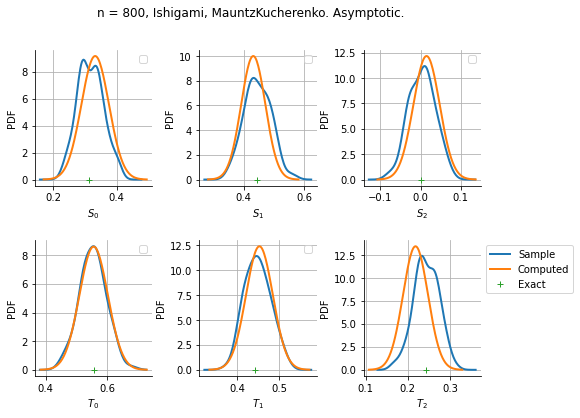

In [4]:
numberOfRepetitions = 100  # Larger is better
problem = otb.IshigamiSensitivity()
metaSAAlgorithm = otb.SensitivityBenchmarkMetaAlgorithm(problem)
for sampleSize in [100, 200, 400, 800]:
    print("sampleSize=", sampleSize)
    for useAsymptotic in [False, True]:
        if useAsymptotic:
            label = "Asymptotic"
        else:
            label = "Bootstrap"
        print(label)
        ot.ResourceMap.SetAsBool(
            "SobolIndicesAlgorithm-DefaultUseAsymptoticDistribution", useAsymptotic
        )
        for estimator in ["Saltelli", "Martinez", "Jansen", "MauntzKucherenko"]:
            print("Estimator:", estimator)
            benchmark = otb.SensitivityDistribution(
                problem,
                metaSAAlgorithm,
                sampleSize,
                numberOfRepetitions=numberOfRepetitions,
                estimator=estimator,
            )
            grid = benchmark.draw()
            view = otv.View(grid)
            figure = view.getFigure()
            _ = figure.suptitle(
                "n = %d, %s, %s. %s."
                % (sampleSize, problem.getName(), estimator, label)
            )
            _ = figure.set_figwidth(8.0)
            _ = figure.set_figheight(6.0)
            _ = figure.subplots_adjust(wspace=0.4, hspace=0.4)
            # Customize legends
            ax = figure.get_axes()
            for i in range(len(ax) - 1):
                _ = ax[i].legend("")
            _ = ax[-1].legend(bbox_to_anchor=(1.0, 1.0))
            _ = pl.show()

The plot compare two distributions.
- The "Computed" distribution is the one computed by OpenTURNS.
- The "Sample" distribution is the one generated by Monte-Carlo sampling.

The fact that the "Computed" distribution is not centered on the true value is an expected property of the way the distribution is computed. What must be checked, instead, is the the variance of the distribution. More precisely, we check that the asymptotic covariance is correctly computed by the library. In other words, we focus on the spread of the distribution and check that it is consistent with the actual spread. This comparison is, however, restricted by the fact that the re-sampling size has a limited size equal to the `numberOfRepetitions` parameter. Increasing this parameter allows the check to be more accurate, but increases the simulation elapsed time. 

We see that these distributions are never far away from each other. This proves that the computation of the distribution is correct, for both the asymptotic and bootstrap options.